# TFLite with MobileNet for Image Classification at the Edge for Chest X-Ray Scanning

AI Models working at the Edge might introduce great ease to our daily life, these benefits could be applied to a wide range of domains such as retail & fashion and health. In recent years AI is being used for supporting the medical examination, I believe this could prevent false diagnosis, if we deploy such systems as decision support to doctors. The impact that AI system creates in terms of preserving the human health is huge and it may further accelerate the medical examination processes. 

In this notebook I show how we can achieve to identify whether a Chest X-Ray Scanning contains a PNEUMONIA or not, by training a few latter layers of a pretrained MobileNet, in the TF framework and then we export our model as tf.lite ready to be deployed to our mobile app to serve us as mobile Chest X-Ray Examiner!

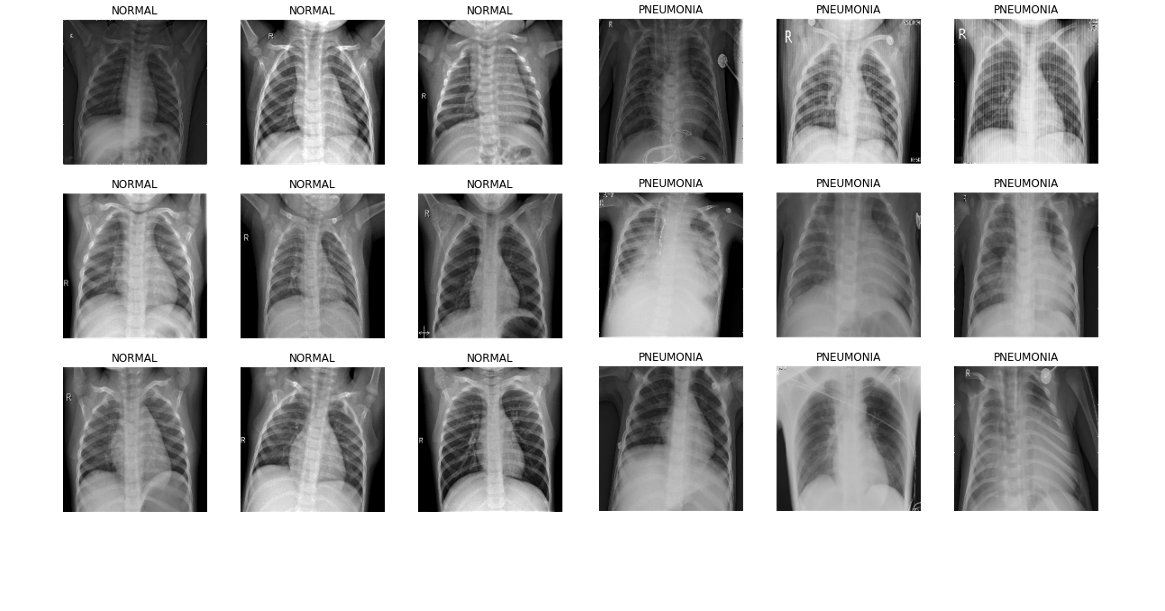

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras import layers
from tensorflow.keras import Model

import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tqdm import tqdm

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

#tf.config.optimizer.set_jit(True)

#from numpy.random import seed
#seed(16)
#tf.random.set_seed(32)

module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

• Using TensorFlow Version: 2.4.1
• Using TensorFlow Hub Version:  0.12.0
• GPU Device Found.
Num GPUs Available:  1
Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Data Preprocessing

In [2]:
train_dir = '../input/chest-xray-pneumonia/chest_xray/train'
val_dir = '../input/chest-xray-pneumonia/chest_xray/val'

In [3]:
NORMAL_dir = os.path.join(train_dir, 'NORMAL')
NORMAL_fnames = os.listdir(NORMAL_dir)
print(len(NORMAL_fnames))

1341


In [4]:
PNEUMONIA_dir = os.path.join(train_dir, 'PNEUMONIA')
PNEUMONIA_fnames = os.listdir(PNEUMONIA_dir)
print(len(PNEUMONIA_fnames))

3875


In [5]:
def format_example(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x/255.0

    return x

In [6]:
from keras.preprocessing import image
pose_name = 'NORMAL'
folder = train_dir+'/'+pose_name

In [7]:
images = []
images_org = []
folder = folder
for img in os.listdir(folder):
    img_imp = image.load_img(folder+'/'+img, target_size=(224, 224))
    x = format_example(img_imp)
    images.append(x)
    images_org.append(img_imp)

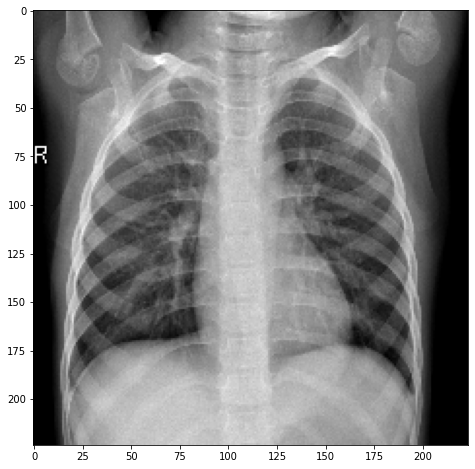

In [8]:
plt.figure(figsize=(10,8))
plt.imshow(images_org[11], cmap=plt.cm.binary)

In [9]:
batch_size = 128

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 90,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   brightness_range=(0.4, 1.0),
                                   horizontal_flip = True,
                                   channel_shift_range=80.0,
                                   vertical_flip = True)

# Note that the validation data should not be augmented!
valid_datagen = ImageDataGenerator( rescale = 1.0/255.)

# Flow training images in batches of batch_size using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    target_size = (224, 224),
                                                    seed=42,
                                                    shuffle=True)     

# Flow validation images in batches of batch_size using test_datagen generator
validation_generator =  valid_datagen.flow_from_directory(val_dir,
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary', 
                                                          target_size = (224, 224),
                                                          seed=42,
                                                          shuffle=True)

labels_list = list(train_generator.class_indices.keys())
label_dict = train_generator.class_indices

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [10]:
print(labels_list)

['NORMAL', 'PNEUMONIA']


In [11]:
print(label_dict)

{'NORMAL': 0, 'PNEUMONIA': 1}


## Defining the Model

In [12]:
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.999):
          print("\nReached 99.9% accuracy so cancelling training!")
          self.model.stop_training = True

In [13]:
do_fine_tuning = True #@param {type:"boolean"}

feature_extractor = hub.KerasLayer(MODULE_HANDLE, input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)
num_classes = 2

print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')])

model.summary()

#@title (Optional) Unfreeze some layers
NUM_LAYERS = 8 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
    feature_extractor.trainable = True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True
else:
    feature_extractor.trainable = False

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


## Training the Model

In [14]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

#We may need to create a model checkpoint 
#for large datasets and also we may require running the py script from the console. 
#Since we do note have GBs of data, we may skip this step
#checkpoint_filepath = 'XRay_Model/checkpoint' 
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

EPOCHS = 100 #In this version, we aim at the max val_accuracy with callbacks > 99.9% val_accuracy
callbacks = myCallback()
hist = model.fit(train_generator,
                 epochs=EPOCHS,
                 validation_data=validation_generator,
                 callbacks=[callbacks])

Epoch 1/100
41/41 [==============================] - 157s 4s/step - loss: 0.4282 - accuracy: 0.8448 - val_loss: 1.0392 - val_accuracy: 0.6250
Epoch 2/100
41/41 [==============================] - 135s 3s/step - loss: 0.2170 - accuracy: 0.9486 - val_loss: 1.0855 - val_accuracy: 0.6875
Epoch 3/100
41/41 [==============================] - 135s 3s/step - loss: 0.1984 - accuracy: 0.9537 - val_loss: 1.6397 - val_accuracy: 0.6250
Epoch 4/100
41/41 [==============================] - 134s 3s/step - loss: 0.1808 - accuracy: 0.9635 - val_loss: 0.8264 - val_accuracy: 0.6875
Epoch 5/100
41/41 [==============================] - 134s 3s/step - loss: 0.1810 - accuracy: 0.9621 - val_loss: 0.3196 - val_accuracy: 0.8750
Epoch 6/100
41/41 [==============================] - 133s 3s/step - loss: 0.1626 - accuracy: 0.9709 - val_loss: 0.1979 - val_accuracy: 0.9375
Epoch 7/100
41/41 [==============================] - 136s 3s/step - loss: 0.1562 - accuracy: 0.9706 - val_loss: 0.2059 - val_accuracy: 0.9375
Epoch 

## Export the Model

In [15]:
from tensorflow.keras.models import load_model
SAVED_MODEL = "XRay_Model"

# Export the SavedModel
tf.saved_model.save(model, SAVED_MODEL)

# Convert Using TFLite's Converter
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)

#converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_file = 'XRay_Model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

## Evaluating the Performance on Unseen Data

In [16]:
# Load TFLite model and allocate tensors.
with open("XRay_Model.tflite", 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [17]:
test_folder = '../input/chest-xray-pneumonia/chest_xray/test'

In [18]:
os.listdir(test_folder)

['PNEUMONIA', 'NORMAL']

In [19]:
NORMAL_class_name = 'NORMAL'
PNEUMONIA_class_name = 'PNEUMONIA'

In [20]:
test_folder_NORMAL = test_folder+'/'+NORMAL_class_name
test_folder_PNEUMONIA = test_folder+'/'+PNEUMONIA_class_name

In [21]:
from keras.preprocessing import image

In [22]:
label_dict[NORMAL_class_name]

0

In [23]:
label_dict[PNEUMONIA_class_name]

1

In [24]:
def get_predictions(folder):
    images = []
    images_org = []
    for img in os.listdir(folder):
        img_imp = image.load_img(folder+'/'+img, target_size=(224, 224))
        x = format_example(img_imp)
        images.append(x)
        images_org.append(img_imp)
    predictions = []
    for i in images:
        interpreter.set_tensor(input_index, i)
        interpreter.invoke()
        prediction_array = interpreter.get_tensor(output_index)
        predictions.append(prediction_array)    
    labels= []
    for j in predictions:
        predicted_label = np.argmax(j)
        labels.append(predicted_label)
    return labels

In [25]:
preds_NORMAL = get_predictions(test_folder_NORMAL)
preds_PNEUMONIA = get_predictions(test_folder_PNEUMONIA)

In [26]:
print(preds_NORMAL)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]


In [27]:
print(preds_PNEUMONIA)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [28]:
print(len(preds_NORMAL), len(preds_PNEUMONIA))

234 390


In [29]:
from sklearn.metrics import accuracy_score

Checking model performance on healthy images:

In [30]:
accuracy_score(234*[label_dict[NORMAL_class_name]], preds_NORMAL)

0.8418803418803419

Checking model performance on images with disease:

In [31]:
accuracy_score(390*[label_dict[PNEUMONIA_class_name]], preds_PNEUMONIA)

0.9564102564102565

and the overall score:

In [32]:
accuracy_score(234*[label_dict[NORMAL_class_name]] + 390*[label_dict[PNEUMONIA_class_name]], preds_NORMAL + preds_PNEUMONIA)

0.9134615384615384

## Let's Visualize!

Text(0.5, 69.0, 'Predicted')

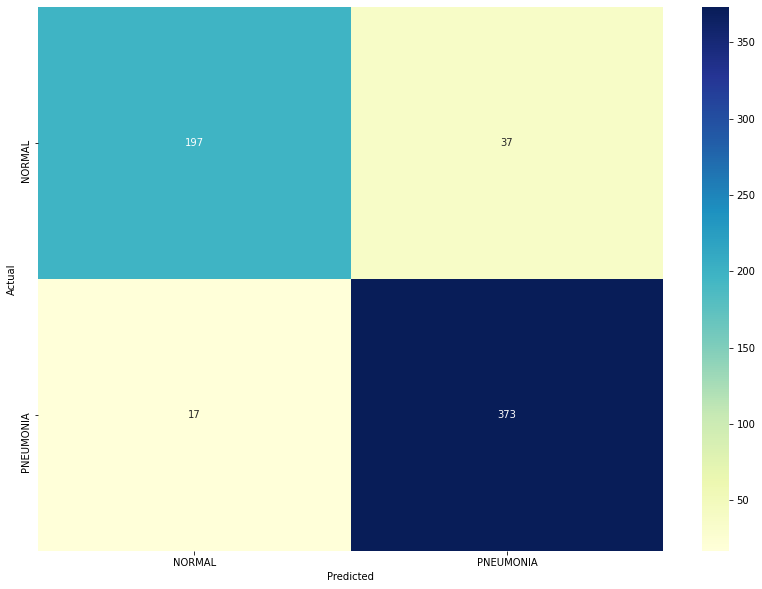

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

plt.figure(figsize=(14,10))
conf_mat = confusion_matrix(234*[label_dict[NORMAL_class_name]] + 390*[label_dict[PNEUMONIA_class_name]], preds_NORMAL + preds_PNEUMONIA)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu",
            xticklabels=labels_list, yticklabels=labels_list)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [34]:
def set_batch(label):
    pose_name = label
    folder = train_dir+'/'+pose_name
    images = []
    images_org = []
    folder = folder
    for img in os.listdir(folder):
        img_imp = image.load_img(folder+'/'+img, target_size=(224, 224))
        x = format_example(img_imp)
        images.append(x)
        images_org.append(img_imp)
    return images_org

In [35]:
def plot_batch(label):
    images_org = set_batch(label)
    plt.figure(figsize=(10,10))
    for n in range(9):
        ax = plt.subplot(3,3 ,n+1)
        plt.imshow(images_org[n])
        plt.title(label)
        plt.axis("off")

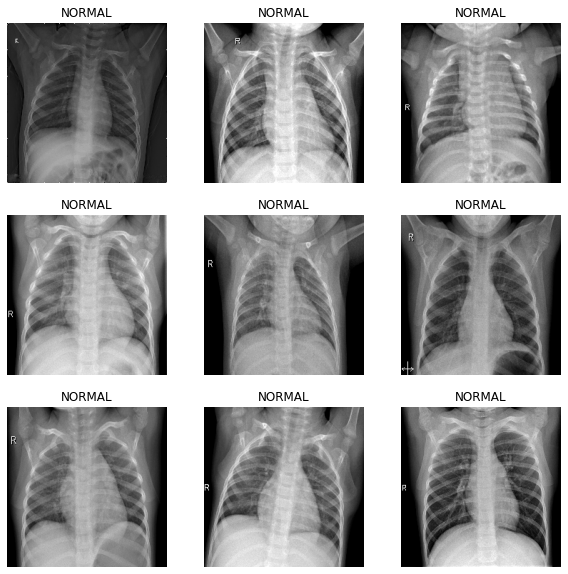

In [36]:
plot_batch('NORMAL')
plt.savefig('NORMAL.png')

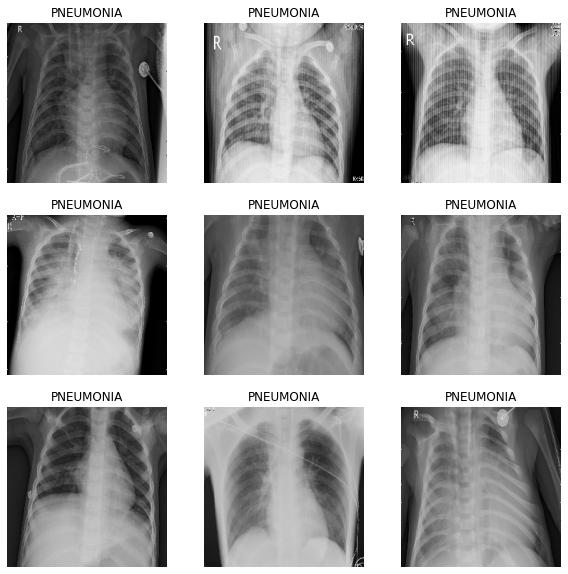

In [37]:
plot_batch('PNEUMONIA')
plt.savefig('PNEUMONIA.png')